EDA for our RNN Model

In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import downloader
import numpy as np
import re
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
WORD_2_VEC_PATH = 'word2vec-google-news-300'
GLOVE_PATH = 'glove-twitter-200'

In [ ]:
class SentimentDataSet(Dataset):

    def __init__(self, file_path, vector_type, tokenizer=None):
        self.file_path = file_path
        data = pd.read_csv(self.file_path)
        data['emotion'] = data['emotion'].replace({ 'sadness': 0,'happiness': 1,'neutral':2})
        self.sentences = data['content'].tolist()
        self.labels = data['emotion'].tolist()
        self.tags_to_idx = {tag: idx for idx, tag in enumerate(sorted(list(set(self.labels))))}
        self.idx_to_tag = {idx: tag for tag, idx in self.tags_to_idx.items()}
        self.vector_type = vector_type
        if vector_type == 'tf-idf':
            if tokenizer is None:
                self.tokenizer = TfidfVectorizer(lowercase=True, stop_words=None)
                self.tokenized_sen = self.tokenizer.fit_transform(self.sentences)
            else:
                self.tokenizer = tokenizer
                self.tokenized_sen = self.tokenizer.transform(self.sentences)
            self.vector_dim = len(self.tokenizer.vocabulary_)
        else:
            if vector_type == 'w2v':
                model = downloader.load(WORD_2_VEC_PATH)
            elif vector_type == 'glove':
                model = downloader.load(GLOVE_PATH)
            else:
                raise KeyError(f"{vector_type} is not a supported vector type")
            representation, labels = [], []
            for sen, cur_labels in zip(self.sentences, self.labels):
                cur_rep = []
                for word in sen.split():
                    word = re.sub(r'\W+', '', word.lower()) # get representation for each word
                    if word not in model.key_to_index:
                        continue
                    vec = model[word]
                    cur_rep.append(vec)
                if len(cur_rep) == 0:
                    print(f'Sentence {sen} cannot be represented!')
                    continue
                cur_rep = np.stack(cur_rep).mean(axis=0)  # HW TODO: change to token level classification
                representation.append(cur_rep)
                labels.append(cur_labels)
            self.labels = labels
            representation = np.stack(representation)
            self.tokenized_sen = representation
            self.vector_dim = representation.shape[-1]

    def __getitem__(self, item):
        cur_sen = self.tokenized_sen[item]
        if self.vector_type == 'tf-idf':
            cur_sen = torch.FloatTensor(cur_sen.toarray()).squeeze()
        else:
            cur_sen = torch.FloatTensor(cur_sen).squeeze()
        label = self.labels[item]
        label = self.tags_to_idx[label]
        data = {"input_ids": cur_sen, "labels": label}
        return data

    def __len__(self):
        return len(self.labels)

The SentimentDataSet class preprocesses our data and encodes sentiment labels numerically. It then generates word embedding representations of sentences using pre-trained models like Word2Vec or Glove. These embeddings are averaged to create sentence-level representations, which are converted into PyTorch tensors along with their corresponding labels. The class provides methods to access individual samples and calculate the total number of samples in our dataset, facilitating the training of sentiment analysis models.

EDA for our LSTM Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout
from keras.optimizers import Adam

train_data = pd.read_csv("trainEmotions.csv")
test_data = pd.read_csv("testEmotions.csv")


In [ ]:
def preprocess_data(data):

    label_encoder = LabelEncoder()
    data['label'] = label_encoder.fit_transform(data['emotion'])

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data['content'])
    X = tokenizer.texts_to_sequences(data['content'])
    X = pad_sequences(X, maxlen=100)
    y = data['label']

    return X, y, tokenizer.word_index


In [ ]:
X_train, y_train, word_index = preprocess_data(train_data)
X_test, y_test, _ = preprocess_data(test_data)


For our LSTM model, we choose to encodes the sentiment labels using LabelEncoder and tokenize the text. The tokenized sequences are then padded to a fixed lenghts (we choose a lenght of 100). Finally, it splits the data into training and validation set (90% for training set and 10% for validation set).

*****************************

**RNN Model**

In [ ]:
from torch import nn


class SentimentNN(nn.Module):

    def __init__(self, vec_dim, num_classes=3, hidden_dim=100):
        super(SentimentNN, self).__init__()
        self.first_layer = nn.Linear(vec_dim, hidden_dim)
        self.second_layer = nn.Linear(hidden_dim, num_classes)
        self.activation = nn.ReLU()
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input_ids, labels=None):
        x = self.first_layer(input_ids)
        x = self.activation(x)
        x = self.second_layer(x)
        if labels is None:
            return x, None
        loss = self.loss(x, labels)
        return x, loss

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader


def train(model, data_sets, optimizer, num_epochs: int, batch_size=16):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data_loaders = {"train": DataLoader(data_sets["train"], batch_size=batch_size, shuffle=True),
                    "test": DataLoader(data_sets["test"], batch_size=batch_size, shuffle=False)}
    model.to(device)

    best_acc = 0.0
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            labels, preds = [], []

            for batch in data_loaders[phase]:
                batch_size = 0
                for k, v in batch.items():
                    batch[k] = v.to(device)
                    batch_size = v.shape[0]

                optimizer.zero_grad()
                if phase == 'train':
                    outputs, loss = model(**batch)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs, loss = model(**batch)
                pred = outputs.argmax(dim=-1).clone().detach().cpu()
                labels += batch['labels'].cpu().view(-1).tolist()
                preds += pred.view(-1).tolist()
                running_loss += loss.item() * batch_size

            epoch_loss = running_loss / len(data_sets[phase])
            epoch_acc = accuracy_score(labels, preds)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                test_losses.append(epoch_loss)
                test_accs.append(epoch_acc)

            epoch_acc = round(epoch_acc, 5)

            if phase.title() == "test":
                print(f'{phase.title()} Loss: {epoch_loss:.4e} Accuracy: {epoch_acc}')
            else:
                print(f'{phase.title()} Loss: {epoch_loss:.4e} Accuracy: {epoch_acc}')
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                with open('model.pkl', 'wb') as f:
                    torch.save(model, f)
        print()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    y_true = []
    y_pred = []

    for batch in data_loaders['test']:
        batch_size = batch['labels'].shape[0]
        with torch.no_grad():
            outputs, _ = model(**batch)
        pred = outputs.argmax(dim=-1).clone().detach().cpu()
        y_true += batch['labels'].cpu().view(-1).tolist()
        y_pred += pred.view(-1).tolist()

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['happiness', 'sadness', 'neutral'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Best Test Accuracy: {best_acc:4f}')


Using tf-idf representation

created train
Epoch 1/5
----------
Train Loss: 8.8523e-01 Accuracy: 0.58929
Test Loss: 1.0825e+00 Accuracy: 0.4999

Epoch 2/5
----------
Train Loss: 5.0640e-01 Accuracy: 0.80771
Test Loss: 1.3052e+00 Accuracy: 0.47695

Epoch 3/5
----------
Train Loss: 2.6247e-01 Accuracy: 0.91637
Test Loss: 1.5151e+00 Accuracy: 0.48439

Epoch 4/5
----------
Train Loss: 1.4503e-01 Accuracy: 0.95463
Test Loss: 1.8364e+00 Accuracy: 0.46351

Epoch 5/5
----------
Train Loss: 8.7726e-02 Accuracy: 0.97373
Test Loss: 1.9274e+00 Accuracy: 0.48088



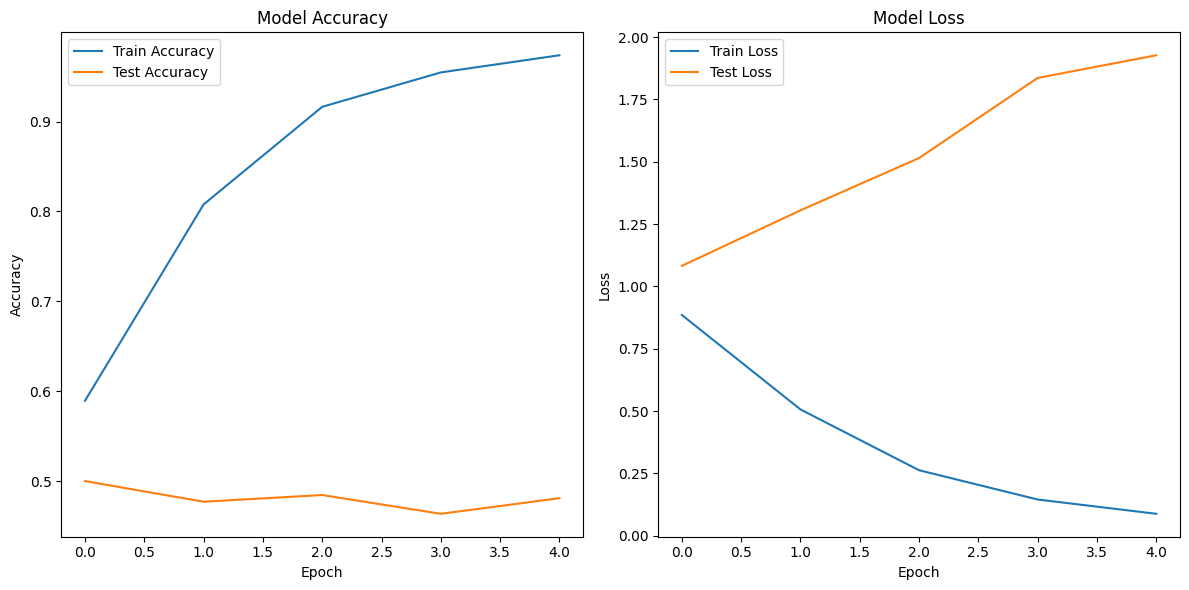

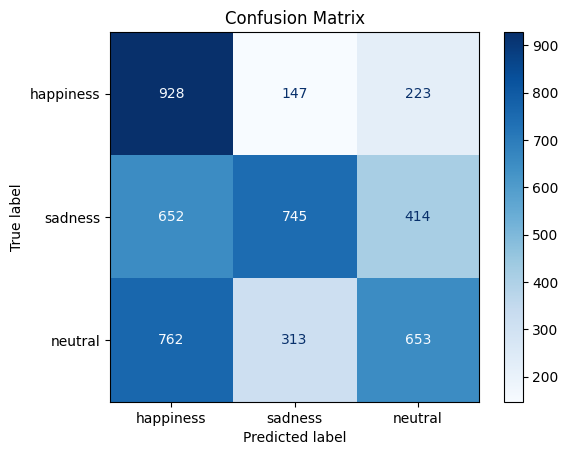

Best Test Accuracy: 0.499900


In [ ]:
from sklearn.model_selection import train_test_split
from torch.optim import Adam

train_ds = SentimentDataSet('trainEmotions.csv', vector_type='tf-idf')
print('created train')
test_ds = SentimentDataSet('testEmotions.csv', vector_type='tf-idf', tokenizer=train_ds.tokenizer)
datasets = {"train": train_ds, "test": test_ds}
nn_model = SentimentNN(num_classes=3, vec_dim=train_ds.vector_dim)
optimizer = Adam(params=nn_model.parameters())
train(model=nn_model, data_sets=datasets, optimizer=optimizer, num_epochs=5)

Using Word2Vec representations

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Sentence Goooooodmorning cannot be represented!
Sentence @MandyyJirouxx  HELLOOOO !!! cannot be represented!
Sentence @Chambers_ Hahaaaha cannot be represented!
Sentence Goodmorning cannot be represented!
Sentence @artcon http://twitpic.com/4vfcx - awesomeeeeee cannot be represented!
Sentence goodmorning ! cannot be represented!
Sentence @Krisbellmusic  yeaaa! cannot be represented!
Sentence @carljohnston cannot be represented!
Sentence BYEEEEE!!! cannot be represented!
Sentence Pinkberry cannot be represented!
Sentence @sharonhayes #twappy http://bit.ly/D9qVk cannot be represented!
Sentence @oliyoung cannot be represented!
Sentence Chilliin cannot be represented!
Sentence Im.in.the.room Im.watching.the.HANNAHmovie.withMOM.She.said.this.film.very.great. cannot be represented!
Sentence roughnight cannot be represented!
Sentence @shortstackband grrrrrrrrrrrrrrrrrrrrrrrr cannot be represented!
Sentence 

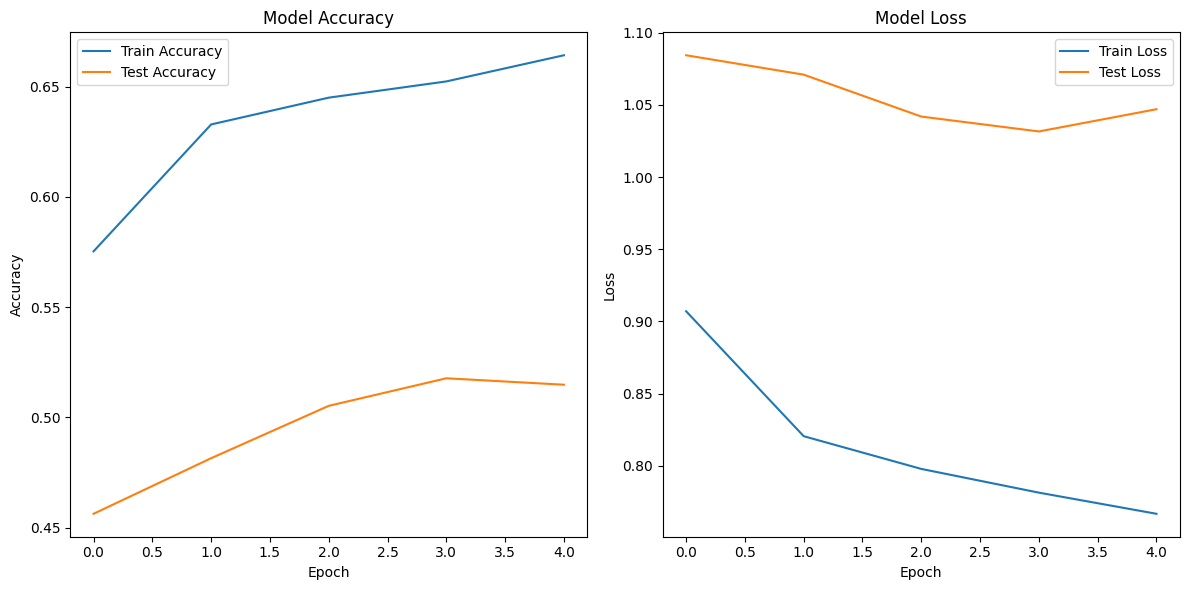

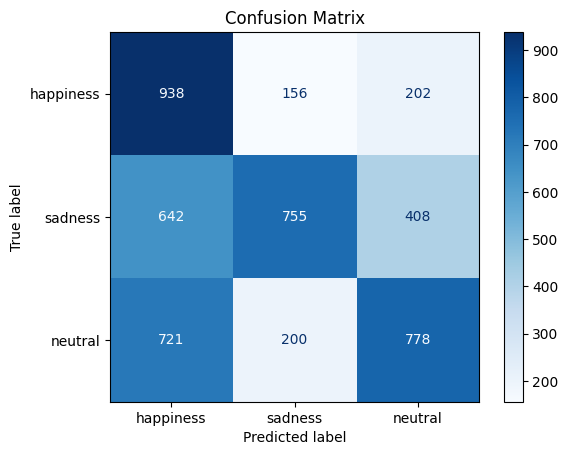

Best Test Accuracy: 0.517710


In [ ]:
train_ds = SentimentDataSet('trainEmotions.csv', vector_type='w2v')
print('created train')
test_ds = SentimentDataSet('testEmotions.csv', vector_type='w2v')
datasets = {"train": train_ds, "test": test_ds}
nn_model = SentimentNN(num_classes=3, vec_dim=train_ds.vector_dim)
optimizer = Adam(params=nn_model.parameters())
train(model=nn_model, data_sets=datasets, optimizer=optimizer, num_epochs=5)

Using Glove representations

[==================================================] 100.0% 758.5/758.5MB downloaded
Sentence @MandyyJirouxx  HELLOOOO !!! cannot be represented!
Sentence @artcon http://twitpic.com/4vfcx - awesomeeeeee cannot be represented!
Sentence @Krisbellmusic  yeaaa! cannot be represented!
Sentence @carljohnston cannot be represented!
Sentence BYEEEEE!!! cannot be represented!
Sentence @sharonhayes #twappy http://bit.ly/D9qVk cannot be represented!
Sentence @oliyoung cannot be represented!
Sentence Chilliin cannot be represented!
Sentence Im.in.the.room Im.watching.the.HANNAHmovie.withMOM.She.said.this.film.very.great. cannot be represented!
Sentence @shortstackband grrrrrrrrrrrrrrrrrrrrrrrr cannot be represented!
Sentence x]loveyoutoo! cannot be represented!
Sentence @shortiee31 cannot be represented!
Sentence &lt;3 alayellow cannot be represented!
Sentence Subway=yum! cannot be represented!
Sentence @britblackbird  youstinkatrespondingtotexts! cannot be represented!
Sentence seepin'. cannot be

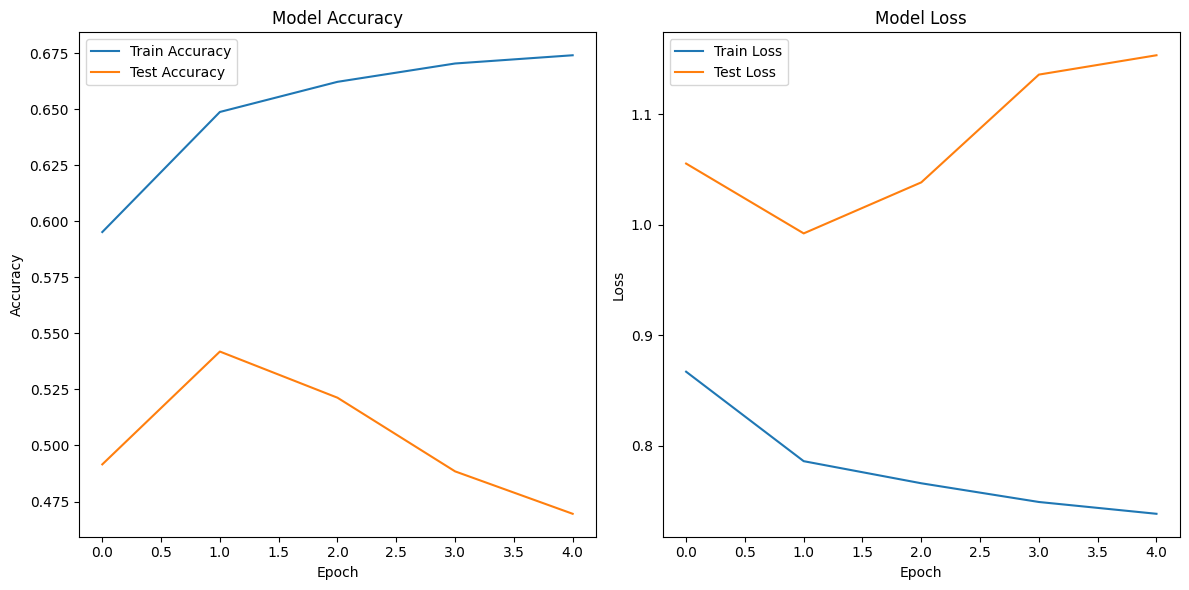

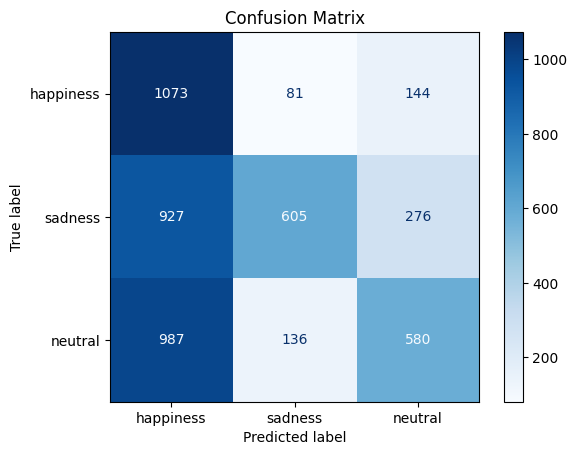

Best Test Accuracy: 0.541900


In [ ]:
from sklearn.model_selection import train_test_split
from torch.optim import Adam

train_ds = SentimentDataSet('trainEmotions.csv', vector_type='glove')
print('created train')
test_ds = SentimentDataSet('testEmotions.csv', vector_type='glove')
datasets = {"train": train_ds, "test": test_ds}
nn_model = SentimentNN(num_classes=3, vec_dim=train_ds.vector_dim)
optimizer = Adam(params=nn_model.parameters())
train(model=nn_model, data_sets=datasets, optimizer=optimizer, num_epochs=5)

**LSTM Model**

In [ ]:
from keras.optimizers import Adam

def build_model(embedding_dim=100, lstm_units=128, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_dim, input_length=X_train.shape[1]))
    model.add(LSTM(lstm_units, dropout=dropout_rate))
    model.add(Dense(3, activation='softmax'))

    return model

model = build_model()
optimizer = Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')


Epoch 1/10
227/227 [==============================] - 90s 375ms/step - loss: 0.9340 - accuracy: 0.5454 - val_loss: 1.2927 - val_accuracy: 0.3878
Epoch 2/10
227/227 [==============================] - 86s 380ms/step - loss: 0.6409 - accuracy: 0.7421 - val_loss: 1.5398 - val_accuracy: 0.3670
Epoch 3/10
227/227 [==============================] - 86s 381ms/step - loss: 0.4054 - accuracy: 0.8467 - val_loss: 1.9053 - val_accuracy: 0.3434
Epoch 4/10
227/227 [==============================] - 87s 385ms/step - loss: 0.2427 - accuracy: 0.9143 - val_loss: 2.4723 - val_accuracy: 0.3386
Epoch 5/10
227/227 [==============================] - 85s 373ms/step - loss: 0.1568 - accuracy: 0.9460 - val_loss: 2.8631 - val_accuracy: 0.3151
Epoch 6/10
227/227 [==============================] - 86s 380ms/step - loss: 0.1101 - accuracy: 0.9621 - val_loss: 3.0753 - val_accuracy: 0.3223
Epoch 7/10
227/227 [==============================] - 87s 385ms/step - loss: 0.0823 - accuracy: 0.9716 - val_loss: 3.4242 - val_ac

Plots of our LSTM Model

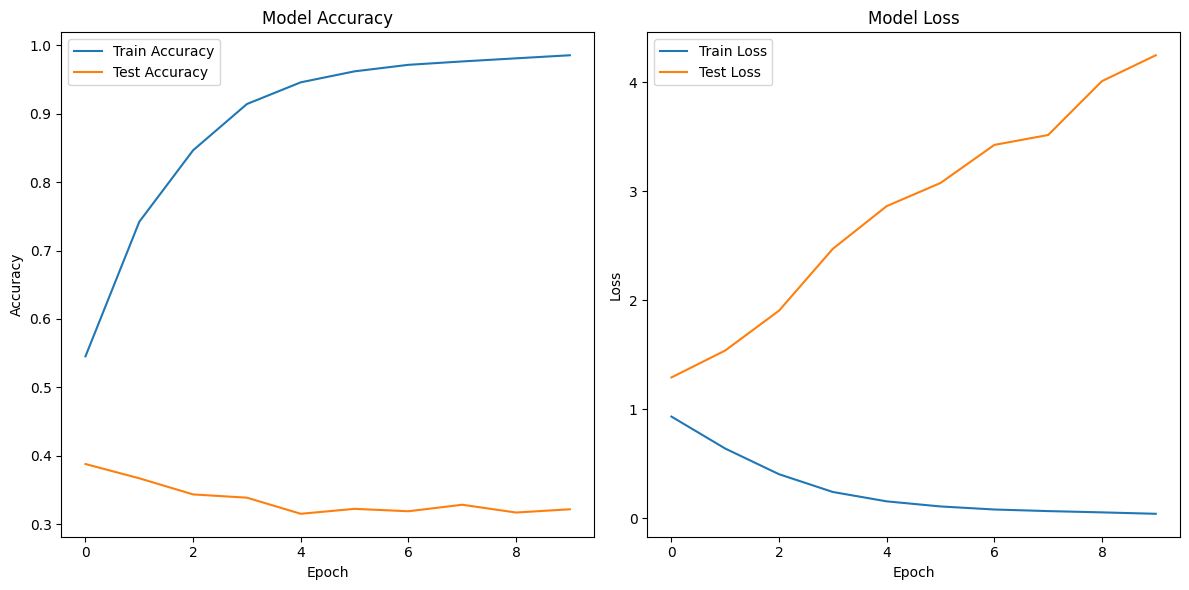

Test accuracy: 0.3216869831085205
152/152 [==============================] - 11s 66ms/step


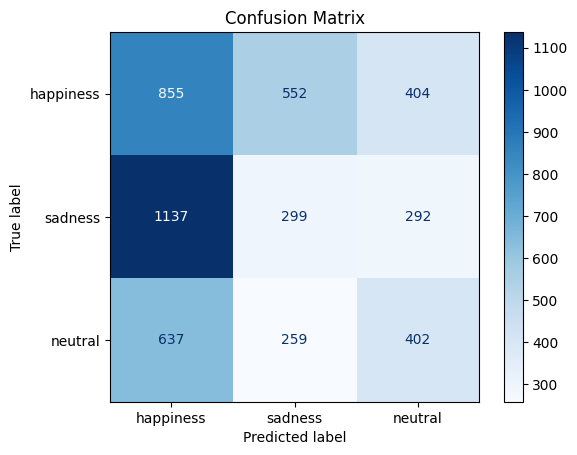

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)
print(f'Test accuracy: {accuracy}')

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['happiness', 'sadness', 'neutral'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

plot_confusion_matrix(y_test, y_pred)


Variation of our LSTM model using SGD optimizer and L2 regularization

In [ ]:
from keras.optimizers import SGD
from keras.regularizers import l2

# Define model with SGD optimizer and L2 regularization
def build_model_sgd(embedding_dim=100, lstm_units=128, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_dim, input_length=X_train.shape[1]))
    model.add(LSTM(lstm_units, dropout=dropout_rate))
    model.add(Dense(3, activation='softmax', kernel_regularizer=l2(0.01)))
    return model

model_sgd = build_model_sgd()
optimizer_sgd = SGD(lr=0.01, momentum=0.9)
model_sgd.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_sgd, metrics=['accuracy'])

history_sgd = model_sgd.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

loss_sgd, accuracy_sgd = model_sgd.evaluate(X_test, y_test)
print(f'Test accuracy with SGD optimizer and L2 regularization: {accuracy_sgd}')


Epoch 1/10
227/227 [==============================] - 84s 354ms/step - loss: 1.1246 - accuracy: 0.3877 - val_loss: 1.1049 - val_accuracy: 0.4267
Epoch 2/10
227/227 [==============================] - 101s 444ms/step - loss: 1.0929 - accuracy: 0.4061 - val_loss: 1.0902 - val_accuracy: 0.4428
Epoch 3/10
227/227 [==============================] - 89s 392ms/step - loss: 1.0793 - accuracy: 0.4071 - val_loss: 1.0846 - val_accuracy: 0.4472
Epoch 4/10
227/227 [==============================] - 97s 428ms/step - loss: 1.0740 - accuracy: 0.4124 - val_loss: 1.0834 - val_accuracy: 0.4505
Epoch 5/10
227/227 [==============================] - 92s 406ms/step - loss: 1.0718 - accuracy: 0.4153 - val_loss: 1.0809 - val_accuracy: 0.4401
Epoch 6/10
227/227 [==============================] - 81s 354ms/step - loss: 1.0703 - accuracy: 0.4166 - val_loss: 1.0792 - val_accuracy: 0.4492
Epoch 7/10
227/227 [==============================] - 82s 364ms/step - loss: 1.0688 - accuracy: 0.4168 - val_loss: 1.0811 - val_a

Variation of our LSTM Model modifying the dropout probbaility, and defining different LSTM units

In [ ]:
from keras.layers import Dropout

# Define model with Adam optimizer, dropout 0f 0.4, and different LSTM units
def build_model_adam(embedding_dim=100, lstm_units=64, dropout_rate=0.4):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embedding_dim, input_length=X_train.shape[1]))
    model.add(LSTM(lstm_units, dropout=dropout_rate))
    model.add(Dense(3, activation='softmax'))
    return model

model_adam = build_model_adam()
optimizer_adam = Adam(lr=0.01)
model_adam.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])

history_adam = model_adam.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

loss_adam, accuracy_adam = model_adam.evaluate(X_test, y_test)
print(f'Test accuracy with our variations of hyperparameters: {accuracy_adam}')


Epoch 1/10
227/227 [==============================] - 53s 220ms/step - loss: 0.9523 - accuracy: 0.5292 - val_loss: 1.3096 - val_accuracy: 0.3816
Epoch 2/10
227/227 [==============================] - 50s 221ms/step - loss: 0.6726 - accuracy: 0.7212 - val_loss: 1.4629 - val_accuracy: 0.3630
Epoch 3/10
227/227 [==============================] - 46s 205ms/step - loss: 0.4690 - accuracy: 0.8213 - val_loss: 1.7300 - val_accuracy: 0.3560
Epoch 4/10
227/227 [==============================] - 50s 222ms/step - loss: 0.3021 - accuracy: 0.8883 - val_loss: 2.2072 - val_accuracy: 0.3355
Epoch 5/10
227/227 [==============================] - 72s 316ms/step - loss: 0.2039 - accuracy: 0.9277 - val_loss: 2.6600 - val_accuracy: 0.3337
Epoch 6/10
227/227 [==============================] - 53s 232ms/step - loss: 0.1442 - accuracy: 0.9486 - val_loss: 2.8468 - val_accuracy: 0.3250
Epoch 7/10
227/227 [==============================] - 55s 243ms/step - loss: 0.1091 - accuracy: 0.9619 - val_loss: 3.4314 - val_ac

*****************************